I need this to figure out noise values. The matrices I'm trying to figure out:
- process noise covariance matrix $Q$
- measurement noise covariance matrix $R$
- state covariance matrix $P$

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('../utils/servo_rotation_data_90/rotation_x.csv')

ax, ay, az = df['Accel_X'].to_numpy(), df['Accel_Y'].to_numpy(), df['Accel_Z'].to_numpy()

df.head()

,Accel_X,Accel_Y,Accel_Z,Magneto_X,Magneto_Y,Magneto_Z,Gyro_X,Gyro_Y,Gyro_Z,Gravity_X,Gravity_Y,Gravity_Z,Quaternion_W,Quaternion_X,Quaternion_Y,Quaternion_Z,Pressure,Temperature,Time
0,-0.45,-0.97,9.76,8.0625,-23.6875,-57.7500,0.0625,0.3125,-0.0625,-0.38,-0.97,9.75,0.109009,-0.024902,-0.047485,0.992615,102313.304688,19.044977,84436.0
1,-0.44,-0.97,9.78,8.8750,-24.3750,-57.0000,0.3125,-0.1250,-0.0625,-0.38,-0.97,9.75,0.109009,-0.024902,-0.047485,0.992615,102313.914062,19.046999,84476.0
2,-0.49,-1.00,9.76,8.8750,-24.3750,-57.0000,-0.1250,0.2500,0.0000,-0.38,-0.97,9.75,0.109009,-0.024902,-0.047485,0.992615,102313.554688,19.046801,84516.0
3,-0.49,-0.96,9.76,8.0625,-23.2500,-55.7500,0.1250,-0.4375,-0.0625,-0.38,-0.97,9.75,0.109009,-0.024902,-0.047485,0.992615,102314.062500,19.048948,84556.0
4,-0.46,-0.97,9.75,7.3750,-24.3750,-57.6875,0.0625,-0.3750,0.1250,-0.38,-0.97,9.75,0.109009,-0.024902,-0.047485,0.992615,102313.312500,19.048264,84596.0


## Process Noise Covariance Matrix
The diagonal elements contain variances for each state variable and off-diagonal elements contain covariances between different state variables. 
We can start off with diagonal matrix with small positive values. Consider the maximum expected change in each state variable. Set diagonal elements to (max_change/3)² to cover 99.7% of possible variations. Adjust based on system performance.

sources: [how to initialise error covariance matrix and process noise covariance matrix](https://www.researchgate.net/post/How-to-initialize-the-error-covariance-matrix-and-process-noise-covariance-matrix-How-are-they-different-and-in-what-way-they-impact-the-filter)



(702, 3)
Covariance Matrix:
[[ 379.6148318    92.61870389    8.70152303]
 [  92.61870389 1143.66658605   67.32004264]
 [   8.70152303   67.32004264   23.622966  ]]


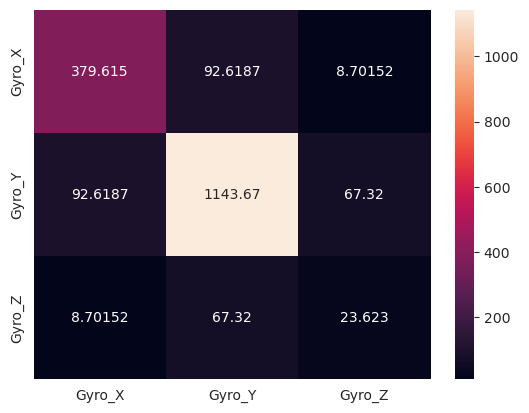

In [13]:
measurement_labels = ['Gyro_X','Gyro_Y','Gyro_Z']
acc_measurements = np.array(df[measurement_labels]) # each 'column' is a new measurement
print(acc_measurements.shape)
covariance_matrix = np.cov(acc_measurements, rowvar=False)
print("Covariance Matrix:")
print(covariance_matrix)

sns.heatmap(covariance_matrix, annot=True, fmt='g', xticklabels=measurement_labels, yticklabels=measurement_labels)
plt.show()

### Measurement Noise Covariance Matrix
We can use manufacturer-provided accuracy specifications,

$$R = \begin{bmatrix}
\sigma_1^2 &0&0\\
0&\sigma_2^2&0\\
0&0&\sigma_3^2\end{bmatrix}$$

where $\sigma_i$ is the sensor's standard deviation. Alternatively,

1. Take multiple static measurements
2. Calculate variance of measurements
3. Use these variances as diagonal elements of R



In [10]:
R_manufactured = np.array([
    [0.01, 0, 0],
    [0, 0.01, 0],
    [0, 0, 0.01]
])

R_empirical = np.array([
    [np.var(ax), 0, 0],
    [0, np.var(ay), 0],
    [0, 0, np.var(az)]
])

print("Manufacturer-proviced accuracy specifications gives: \n",R_manufactured)
print("Empirically computed variances gives: \n",R_empirical)

acc = np.array([
    df['Accel_X'],
    df['Accel_Y'],
    df['Accel_Z']
]).T
mag = np.array([
    df['Magneto_X'],
    df['Magneto_Y'],
    df['Magneto_Z']
]).T
gyr = np.array([
    df['Gyro_X'],
    df['Gyro_Y'],
    df['Gyro_Z']
]).T

print(f'variance of acceleromenter is {np.var(acc)}')
print(f'variance of magnetometer is {np.var(mag)}')
print(f'variance of gyroscope is {np.var(gyr)}')

Manufacturer-proviced accuracy specifications gives: 
 [[0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]
Empirically computed variances gives: 
 [[17.64214508  0.          0.        ]
 [ 0.          1.27622864  0.        ]
 [ 0.          0.          7.94922529]]
variance of acceleromenter is 33.67835613554157
variance of magnetometer is 1037.3438242641218
variance of gyroscope is 515.0233073772738


### Initial State Covariance Matrix
The most common approach is $$P=p\begin{bmatrix}1&0&0\\0&1&0\\0&0&1\end{bmatrix}$$
with $p$ being some large number. Use larger values to indicate high initial uncertainty.


In [11]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def collect_static_orientation_data(time_duration, sampling_rate):
    """
    Collect orientation data while system is static
    Returns: timestamps and concentration parameters
    """
    dt = 1.0 / sampling_rate
    timestamps = np.arange(0, time_duration, dt)
    return timestamps

def estimate_concentration(quaternion_samples):
    """
    Estimate concentration parameter from quaternion samples
    """
    # Calculate scatter matrix
    scatter_matrix = np.zeros((4, 4))
    for q in quaternion_samples:
        scatter_matrix += np.outer(q, q)
    scatter_matrix /= len(quaternion_samples)
    
    # Eigenvalues give information about concentration
    eigenvalues = np.linalg.eigvals(scatter_matrix)
    # Largest eigenvalue relates to concentration
    concentration = -np.log(1 - np.max(eigenvalues))
    return concentration

def exponential_decay(t, initial_concentration, q):
    """
    Model: Z(t) = Z(0) * exp(-q * t)
    """
    return initial_concentration * np.exp(-q * t)

def fit_exponential_decay(timestamps, concentrations):
    """
    Fit exponential decay to concentration data
    """
    popt, pcov = curve_fit(exponential_decay, timestamps, concentrations)
    return popt[0], popt[1], pcov  # initial_concentration, q, covariance

def measure_process_noise():
    # Parameters
    duration = 10.0  # seconds
    sampling_rate = 100  # Hz
    
    # Collect data
    timestamps = collect_static_orientation_data(duration, sampling_rate)
    
    # Simulate or collect real quaternion measurements
    # This is where you'd interface with your actual sensor
    quaternion_samples = []
    concentrations = []
    
    # Calculate concentration parameters over time
    for t in timestamps:
        # Get quaternion samples for this timestamp
        current_samples = get_quaternion_samples(t)  # You need to implement this
        concentration = estimate_concentration(current_samples)
        concentrations.append(concentration)
    
    # Fit exponential decay
    initial_conc, q, pcov = fit_exponential_decay(timestamps, concentrations)
    
    # Calculate uncertainty
    q_std = np.sqrt(pcov[1,1])
    
    return q, q_std

def plot_results(timestamps, concentrations, initial_conc, q):
    plt.figure(figsize=(10, 6))
    plt.scatter(timestamps, concentrations, label='Measured')
    
    # Plot fitted curve
    t_fit = np.linspace(timestamps[0], timestamps[-1], 1000)
    concentrations_fit = exponential_decay(t_fit, initial_conc, q)
    plt.plot(t_fit, concentrations_fit, 'r-', label='Fitted')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Concentration Parameter')
    plt.title('Exponential Decay of Concentration Parameters')
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
timestamps = collect_static_orientation_data()

TypeError: collect_static_orientation_data() missing 2 required positional arguments: 'time_duration' and 'sampling_rate'